# Preliminaries
As first step, we need to download the needed files from the internet and prepare them for the required tasks. First, we import useful libraries.

In [1]:
# import useful libraries
import os
import requests
import zipfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import time
import torch
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import math
import colorsys

## Dataset & devtools download
We frist download the KITTI dataset from the internet and unzip it.

In [2]:
# download dataset from url if not already downloaded
if not os.path.exists("data/kitti.zip"):
    print("Downloading dataset (may take some time)...")

    # create data folder if it does not exist
    if not os.path.exists("data"):
        os.makedirs("data")

    # download KITTI dataset from url
    with open("data/kitti.zip", "wb") as dataset_file:
        url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip"
        response = requests.get(url, allow_redirects=True)
        dataset_file.write(response.content)
    print("Dataset dowloaded succesfully in", os.path.abspath("data/kitti.zip"))

# unzip dataset file if not already
if not os.path.exists("data/kitti"):
    print("Unzipping the dataset...")

    with zipfile.ZipFile("data/kitti.zip","r") as dataset_file:
        dataset_file.extractall("data/kitti")

    print("Dataset unzipped at", os.path.abspath("data/kitti"))

We then download and unzip the DevTools.

In [3]:
# download devtools from url if not already donwloaded
if not os.path.exists("devtools/devtools.zip"):
    print("Downloading devtools (may take some time)...")

    # create devtools folder if it does not exist
    if not os.path.exists("devtools"):
        os.makedirs("devtools")
    
    # download devtools from url
    with open("devtools/devtools.zip", "wb") as devtools_file:
        url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_semantics.zip"
        response = requests.get(url, allow_redirects=True)
        devtools_file.write(response.content)
    print("Devtools downloaded successfully in", os.path.abspath("devtools/devtools.zip"))

# unzip devtools file i# unzip dataset file if not already
if not os.path.exists("devtools/devtools"):
    print("Unzipping the devtools...")

    with zipfile.ZipFile("devtools/devtools.zip","r") as devtools_file:
        devtools_file.extractall("devtools/devtools")

    print("Devtools unzipped at", os.path.abspath("devtools/devtools"))

# Dataset analysis
We know perform the dataset analysis task. This is divided into four tasks that we will cover

## Dataloader and visualizer
The first task of the dataset analysis is the creation of a dataloader and a visualizer for the data in KITTI dataset

### Dataloader
As first task, we create a dataloader to load data from the dataset

In [4]:
# create a PyTorch dataset that represents the KITTI dataset
class KITTIDataset(Dataset):
    """
    PyTorch dataset loading KITTI images
    """

    def __init__(self, image_folder:str, split: str = "training"):
        """
        Constructor method of the class

        :param image_folder: directory containing the images (str)
        :param split: split of the dataset to use (str, default "training")
        """
        super(KITTIDataset, self).__init__()

        # define folder containing images
        self.image_folder = image_folder

        # define split
        self.split = split.lower()

        # define the list containing the names of the files
        self.filenames = sorted(os.listdir(os.path.join(image_folder, split, "image_2")))

        # define transform
        self.transform = transforms.Compose([transforms.Resize((375, 1242)), transforms.ToTensor()])

        
    def __len__(self) -> int:
        """
        Returns the length of the dataset

        :return: length of the dataset
        """

        return len(self.filenames)

    def __getitem__(self, idx) -> tuple:
        """
        Get a HR image and the corresponding LR images in all the scales

        :param idx: the chosen item index in the dataset
        """

        # load the chosen raw image
        raw_image_path = os.path.join(self.image_folder, self.split, "image_2", self.filenames[idx])
        raw_image_file = Image.open(raw_image_path)
        raw_image = self.transform(raw_image_file)
        raw_image_file.close()

        # if split is not test, load annotations
        if self.split != "testing":
            
            # load the chosen instance annotation image
            instance_annotation_path = os.path.join(self.image_folder, self.split, "instance", self.filenames[idx])
            instance_annotation_file = cv2.imread(instance_annotation_path, cv2.IMREAD_UNCHANGED)

            # extract instance_ground_truth
            instance_ground_truth = instance_annotation_file % 256
            instance_ground_truth = instance_ground_truth.astype('int16')
            instance_ground_truth = Image.fromarray(instance_ground_truth)
            instance_annotation = self.transform(instance_ground_truth)

            # load the chosen semantic annotation image
            semantic_annotation_path = os.path.join(self.image_folder, self.split, "semantic", self.filenames[idx])
            semantic_annotation_file = Image.open(semantic_annotation_path)
            semantic_annotation = self.transform(semantic_annotation_file)
            semantic_annotation_file.close()

            # load the chosen semantic rgb annotation image
            semantic_rgb_annotation_path = os.path.join(self.image_folder, self.split, "semantic_rgb", self.filenames[idx])
            semantic_rgb_annotation_file = Image.open(semantic_rgb_annotation_path)
            semantic_rgb_annotation = self.transform(semantic_rgb_annotation_file)
            semantic_rgb_annotation_file.close()

        # otherwise set them to empty tensors
        else:
            # set annotations to None
            instance_annotation = torch.Tensor()
            semantic_annotation = torch.Tensor()
            semantic_rgb_annotation = torch.Tensor()

        
        return raw_image, instance_annotation, semantic_annotation, semantic_rgb_annotation, self.filenames[idx]

Once created the PyTorch dataset, we create training and testing dataset objects and we load batches from them using PyTorch dataloader. Then, we test their speed in extracting the data from the dataset.

In [5]:
# create training and testing dataset objects
training_data = KITTIDataset("data/kitti", split="training")
testing_data = KITTIDataset("data/kitti", split="testing")
# create training and testing dataloaders
training_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=16, shuffle=True)

# test training dataloader
start = time.time()
for raw, instance, semantic, semantic_rgb, file_name in tqdm(training_dataloader):
    pass
end = time.time()

print(end - start)

# test testing dataloader
start = time.time()
for raw, _, _, _, file_name in tqdm(testing_dataloader):
    pass
end = time.time()

print(end - start)

  0%|          | 0/13 [00:00<?, ?it/s]

13.968422889709473


  0%|          | 0/13 [00:00<?, ?it/s]

5.525945425033569


### Visualizer
We now proceed by creating a Visualizer in order to visualize data and annotations. 

In [6]:
# import labels from devtools
from devtools.devtools.devkit.helpers.labels import labels

# extract instance classes from kitti labels array
instance_classes = [{'name': getattr(classes, 'name'), 'color': getattr(classes, 'color')} for classes in labels if getattr(classes, 'hasInstances')]

# create function to extract min and max x and y from instance, along with instance width and height
def min_max_x_y(coordinates: tuple):
    """
    method to extract min and max x and y coordinates of an instance, along with instance width and height

    :param extract: x and y coordinates of the instance pixels (tuple)
    """

    # extract region min and max x and y coordinates for bounding box drawing
    min_x = min(coordinates[1])
    max_x = max(coordinates[1])
    min_y = min(coordinates[0])
    max_y = max(coordinates[0])
    width = abs(min_x - max_x)
    height = abs(min_y - max_y)

    return min_x, max_x, min_y, max_y, width, height


# create a KITTI visualizer method to visualize image and annotations given the image, the instance annotation image and the semantic rgb image
def visualize(raw: np.ndarray, instance: np.ndarray, semantic_rgb: np.ndarray):
    """
    Visualizes image annotations given its raw image, its instance annotations and its semantic rgb 

    :param raw: the raw image (ndarray)
    :param instance: the instance annotation image (ndarray)
    :param semantic_rgb: the semantic rgb image (ndarray)
    """

    # plot raw image
    plt.figure(figsize=(15, 15))
    plt.imshow(raw)
    plt.axis("off")
    plt.show()

    # find all the instance ids in the image and remove duplicates
    instance_ids = np.unique(instance[instance != 0])

    # add raw image to the plot
    fig, ax = plt.subplots(figsize=(15,15))
    ax.axis("off")
    ax.imshow(raw)

    # for each instance in the image, extract the corresponding class
    for current_instance in instance_ids:

        # extract the boolean map of the region where the instance is in the image
        instance_location = instance == current_instance

        # extract the colors representing semantic annotations of the instance region
        semantic_annotation_colors = np.unique(semantic_rgb[instance_location], axis=0).T
        semantic_annotation_colors = list(zip(semantic_annotation_colors[0], semantic_annotation_colors[1], semantic_annotation_colors[2]))

        # for each instance class
        for instance_class in instance_classes:
          
            # if the current instance class is in the semantic rgb annotations of the image
            if instance_class['color'] in semantic_annotation_colors:

                # extract name and color of the image
                region_instance_class = instance_class['name']
                region_instance_color = instance_class['color']

                # extract regions of the semantic rgb image where the current instance class appears
                class_location = semantic_rgb == region_instance_color
                class_location = np.logical_and.reduce(class_location, axis=2)

                # extract class location
                instance_class_location = np.logical_and(class_location, instance_location)

                # extract instance indexes
                instance_indexes = np.where(instance_class_location)

                # compute min and max x and y, along with instance width and height
                min_x, max_x, min_y, max_y, width, height = min_max_x_y(instance_indexes)

                # generate random vivid color 
                h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
                r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]

                # plot instance on image
                patch = np.full((instance_class_location.shape[0], instance_class_location.shape[1], 4), [0, 0, 0, 0], dtype=int)
                patch[instance_class_location] = [r, g, b, math.floor(0.35*255)]
                ax.imshow(patch)

                # plot bounding box on image
                box = patches.Rectangle((min_x, min_y), width, height, linewidth=1.5, linestyle="--", edgecolor=(r/255, g/255, b/255), facecolor='none')
                ax.add_patch(box)

                # plot label patch
                ax.text(min_x, min_y+10, region_instance_class, color="w", fontsize=10)
    
    # show final plot with annotations
    plt.show()

    # plot semantic rgb image
    plt.figure(figsize=(15, 15))
    plt.imshow(semantic_rgb)
    plt.axis("off")
    plt.show()

We then try the visualizer with an image from the training set.

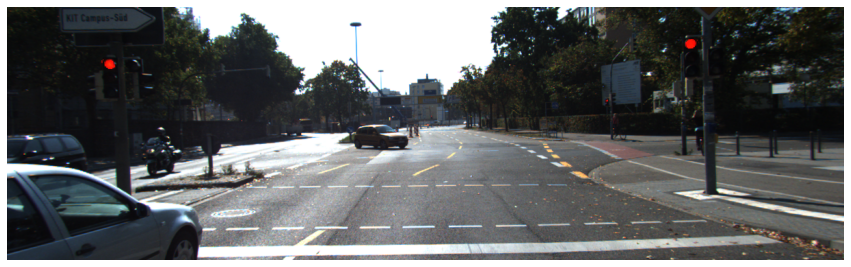

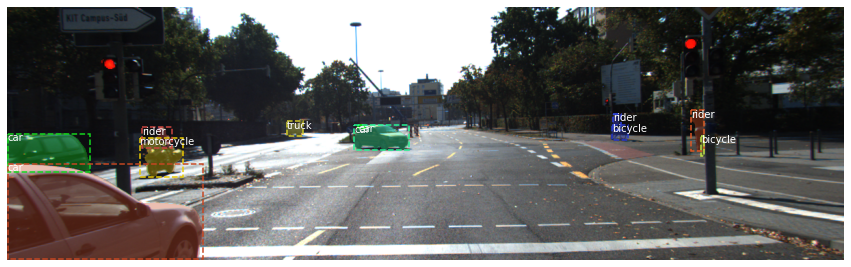

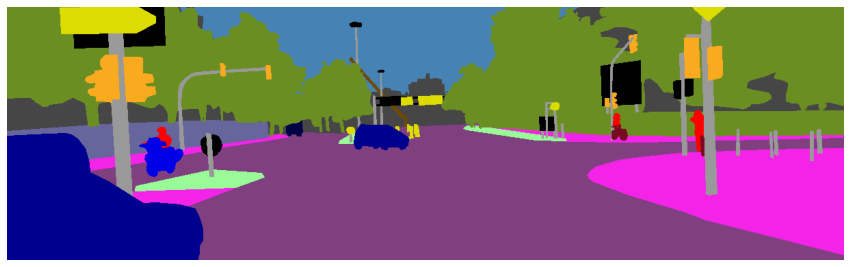

In [7]:
# get image from training set
image_file = "000155_10.png"

# open images
raw = np.array(Image.open(os.path.join("data/kitti/training/image_2", image_file)))
instance = cv2.imread(os.path.join("data/kitti/training/instance", image_file), cv2.IMREAD_UNCHANGED) % 256
semantic = np.array(Image.open(os.path.join("data/kitti/training/semantic", image_file)))
semantic_rgb = np.array(Image.open(os.path.join("data/kitti/training/semantic_rgb", image_file)))

# visualize image and annotations
visualize(raw, instance, semantic_rgb)

## Histograms
We then proceed creating an histogram of pixel occurrences per class and a histogram of instance occurrences per class.


### Histogram of pixel occurrences per class
The first histogram we compute is the histogram of pixel occurrences per class.

In [8]:
# extract all the classes
eval_classes = [{'name': getattr(classes, 'name'), 'id': getattr(classes, 'id'), 'color': getattr(classes, 'color')} for classes in labels]

# create dataloader with 1 sample per batch
dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

# create empty dictionary of pixel occurrences per class
class_pixel_occurrences = {cls['name']: 0 for cls in eval_classes}

# for each sample in the dataset
for _, _, _, semantic_rgb, _ in tqdm(dataloader):
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int)

    # flatten semantic rgb image
    semantic_rgb = semantic_rgb.reshape((semantic_rgb.shape[0]*semantic_rgb.shape[1]), semantic_rgb.shape[2]).numpy()

    # for each class
    for cls in eval_classes:

        # extract current class name, id and color
        class_name = cls['name']
        class_id = cls['id']
        class_color = np.asarray(cls['color'])

        # count the number of current class pixels in the current image 
        class_pixel_occurrences[class_name] += np.count_nonzero(semantic_rgb == class_color)
        

  0%|          | 0/200 [00:00<?, ?it/s]

We then plot the histogram using the previously computed dictionary.

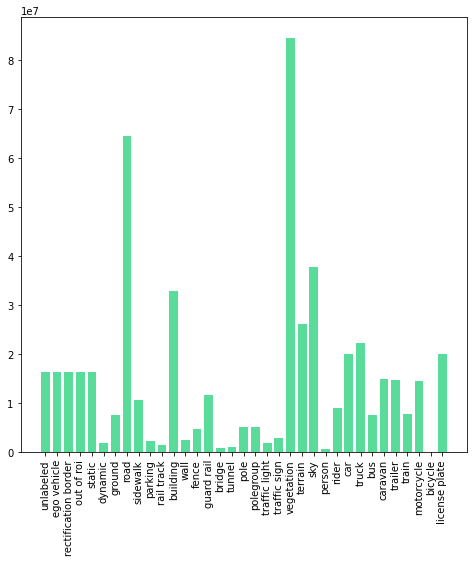

In [9]:
plt.figure(figsize=(8, 8))
plt.xticks(rotation=90)
plt.bar(class_pixel_occurrences.keys(), class_pixel_occurrences.values(), width=0.75, color=(89/255, 220/255, 154/255))
plt.show()

### Histogram of instance occurrences per class
The second histogram we compute is the histogram of instance occurrences per class.

In [10]:
# create empty dictionary of pixel occurrences per class
class_instance_occurrences = {cls['name']: 0 for cls in instance_classes}

# for each sample in the dataset
for _, instance, _, semantic_rgb, _ in tqdm(dataloader):
    instance = (instance.squeeze() * 255).to(torch.int).numpy()
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int).numpy()

    # find all the instances in the image
    instance_ids = np.unique(instance[instance != 0])

    # for each instance in the image, extract the corresponding class(es)
    for current_instance in instance_ids:

        # extract the classes color of the current instance
        instance_location = instance == current_instance
        semantic_annotation_colors = np.unique(semantic_rgb[instance_location], axis=0).T
        semantic_annotation_colors = list(zip(semantic_annotation_colors[0], semantic_annotation_colors[1], semantic_annotation_colors[2]))

        # for each instance class
        for instance_class in instance_classes:
          
            # if the current instance class is in the semantic rgb annotations of the image
            if instance_class['color'] in semantic_annotation_colors:

                # extract name and color of the image
                region_instance_class = instance_class['name']

                # count the number of current class pixels in the current image 
                class_instance_occurrences[region_instance_class] += 1

  0%|          | 0/200 [00:00<?, ?it/s]

We then plot the histogram using the previously computed dictionary.

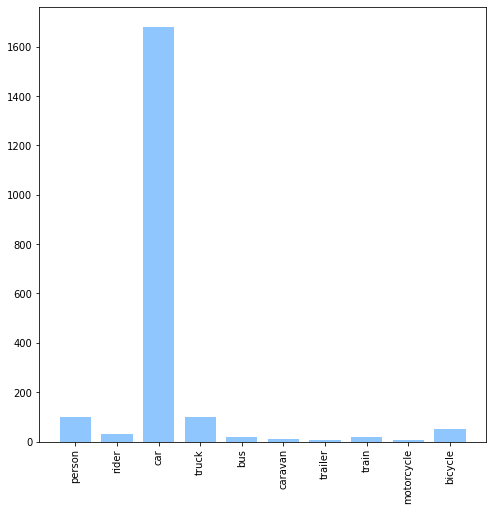

In [11]:
plt.figure(figsize=(8, 8))
plt.xticks(rotation=90)
plt.bar(class_instance_occurrences.keys(), class_instance_occurrences.values(), width=0.75, color=(143/255, 198/255, 253/255))
plt.show()

## Instance segmentation histograms
We now compute the instance segmentation histograms.

### Aspect ratio distribution
We first compute the aspect ratio distribution.

In [12]:
# create empty dictionary of ratio per class
class_ratios = {cls['name']: {} for cls in instance_classes}

# for each sample in the dataset
for _, instance, _, semantic_rgb, _ in tqdm(dataloader):
    instance = (instance.squeeze() * 255).to(torch.int).numpy()
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int).numpy()

    # find all the instances in the image
    instance_ids = np.unique(instance[instance != 0])

    # for each instance in the image, extract the corresponding class(es)
    for current_instance in instance_ids:

        # extract the classes color of the current instance
        instance_location = instance == current_instance
        semantic_annotation_colors = np.unique(semantic_rgb[instance_location], axis=0).T
        semantic_annotation_colors = list(zip(semantic_annotation_colors[0], semantic_annotation_colors[1], semantic_annotation_colors[2]))

        # for each instance class
        for instance_class in instance_classes:
          
            # if the current instance class is in the semantic rgb annotations of the image
            if instance_class['color'] in semantic_annotation_colors:

                # extract name and color of the image
                region_instance_class = instance_class['name']
                region_instance_color = instance_class['color']

                # extract regions of the semantic rgb image where the current instance class appears
                class_location = semantic_rgb == region_instance_color
                class_location = np.logical_and.reduce(class_location, axis=2)

                # extract class location
                instance_class_location = np.logical_and(class_location, instance_location)

                # extract instance indexes
                instance_indexes = np.where(instance_class_location)

                # compute min and max x and y, along with instance width and height
                min_x, max_x, min_y, max_y, width, height = min_max_x_y(instance_indexes)

                # compute ratio of the instance
                if height != 0:
                    instance_ratio = round(width/height, 1)

                    # add ratio to ratios dictionary
                    if instance_ratio not in class_ratios[region_instance_class].keys():
                        class_ratios[region_instance_class][instance_ratio] = 0
                    class_ratios[region_instance_class][instance_ratio] += 1

  0%|          | 0/200 [00:00<?, ?it/s]

Now we plot the histogram of distribution of ratios using the previously computed dictionary.

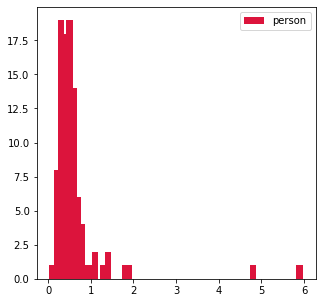

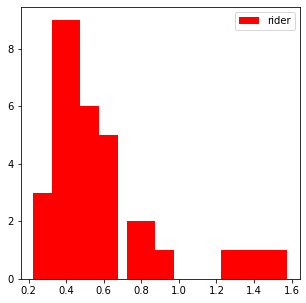

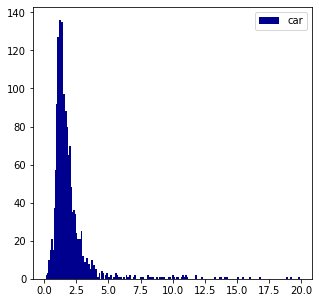

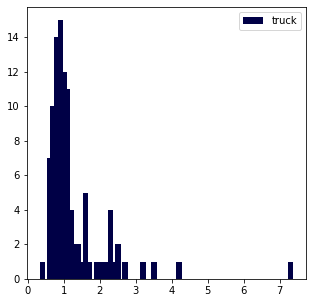

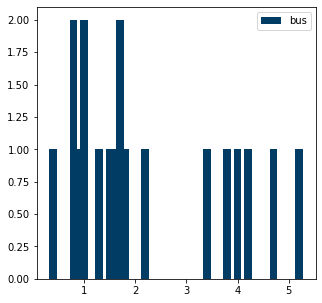

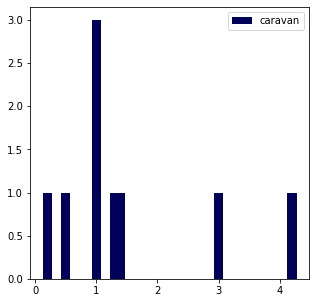

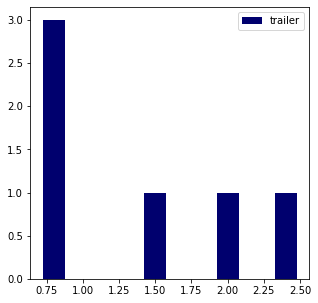

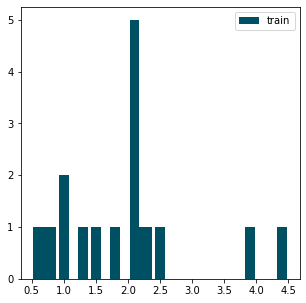

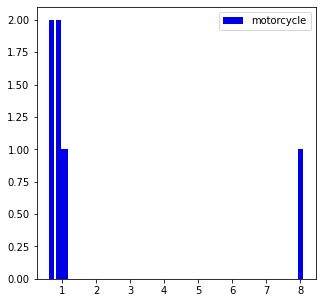

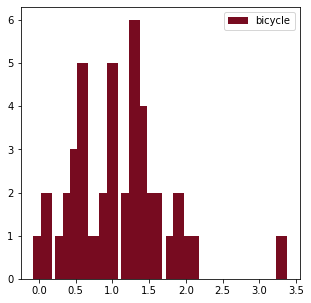

In [13]:
# for each instance class
for instance_class in instance_classes:

    # get class name and color
    class_name = instance_class['name']
    class_color = instance_class['color']

    # get class ratio distribution
    ratio_distribution = class_ratios[class_name]

    # plot ratio distribution histogram
    plt.figure(figsize=(5, 5))
    plt.bar(ratio_distribution.keys(), ratio_distribution.values(), width=0.15, color=(class_color[0]/255, class_color[1]/255, class_color[2]/255), label=class_name)
    plt.legend()
    plt.show()

### Histogram of area distribution
We now compute the histogram of the area distribution.

In [14]:
# create empty dictionary of pixels per class
class_pixels = {cls['name']: {} for cls in instance_classes}

# for each sample in the dataset
for _, instance, _, semantic_rgb, _ in tqdm(dataloader):
    instance = (instance.squeeze() * 255).to(torch.int).numpy()
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int).numpy()

    # find all the instances in the image
    instance_ids = np.unique(instance[instance != 0])

    # for each instance in the image, extract the corresponding class(es)
    for current_instance in instance_ids:

        # extract the classes color of the current instance
        instance_location = instance == current_instance
        semantic_annotation_colors = np.unique(semantic_rgb[instance_location], axis=0).T
        semantic_annotation_colors = list(zip(semantic_annotation_colors[0], semantic_annotation_colors[1], semantic_annotation_colors[2]))

        # for each instance class
        for instance_class in instance_classes:
          
            # if the current instance class is in the semantic rgb annotations of the image
            if instance_class['color'] in semantic_annotation_colors:

                # extract name and color of the image
                region_instance_class = instance_class['name']
                region_instance_color = instance_class['color']

                # extract regions of the semantic rgb image where the current instance class appears
                class_location = semantic_rgb == region_instance_color
                class_location = np.logical_and.reduce(class_location, axis=2)

                # extract class location
                instance_class_location = np.logical_and(class_location, instance_location)

                # compute the ratio of pixels occupied by the instance over the total image
                pixel_instance = instance_class_location.sum()
                total_image_pixels = instance_class_location.shape[0] * instance_class_location.shape[1]
                pixels_occupied = round((pixel_instance / total_image_pixels) * 10000, 1)

                # add occupied area to area dictionary
                if pixels_occupied not in class_pixels[region_instance_class].keys():
                    class_pixels[region_instance_class][pixels_occupied] = 0
                class_pixels[region_instance_class][pixels_occupied] += 1

  0%|          | 0/200 [00:00<?, ?it/s]

Now we plot the histogram of distribution of area using the previously computed dictionary.

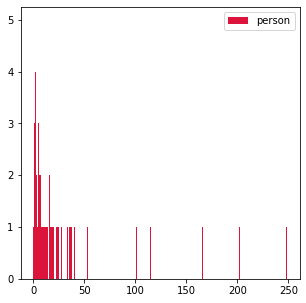

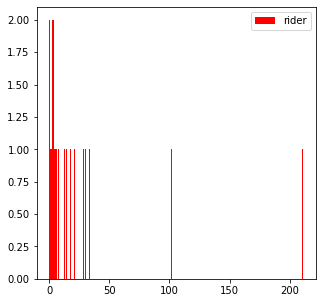

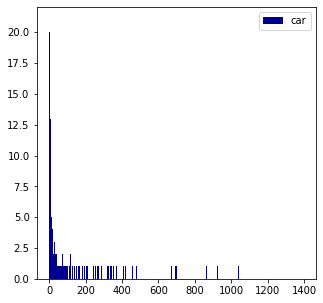

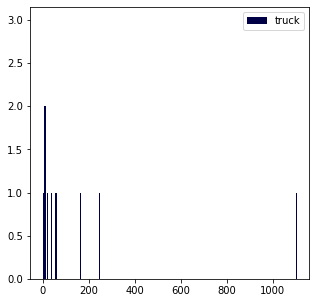

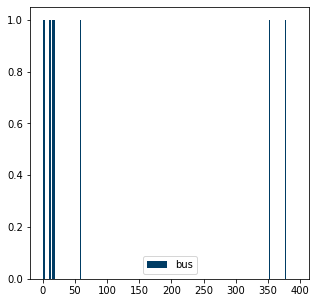

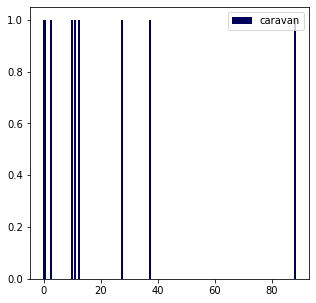

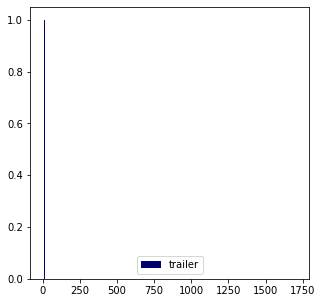

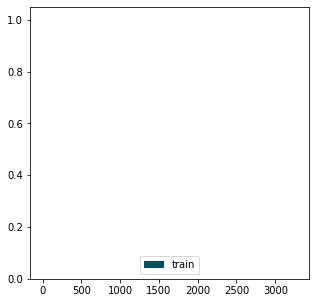

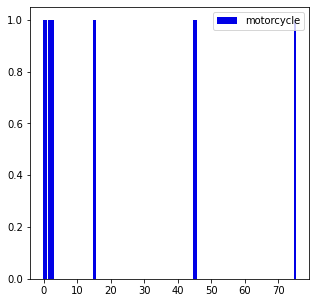

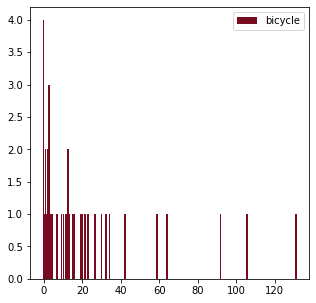

In [15]:
# for each instance class
for instance_class in instance_classes:

    # get class name and color
    class_name = instance_class['name']
    class_color = instance_class['color']

    # get class area distribution
    area_distribution = class_pixels[class_name]

    # plot area distribution histogram
    plt.figure(figsize=(5, 5))
    plt.bar(area_distribution.keys(), area_distribution.values(), color=(class_color[0]/255, class_color[1]/255, class_color[2]/255), label=class_name)
    plt.legend()
    plt.show()

## Semantic segmentation class area maps
Now, we compute the segmentation class area map for each of the classes in the dataset.

In [16]:
# create empty dictionary containing number of class occurrences for each pixel coordinate
class_pixel_occurrences = {}

# for each sample in the dataset
for _, _, semantic, semantic_rgb, _ in tqdm(dataloader):
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int).numpy()

    # for each class 
    for eval_class in eval_classes:

        # get class name and color
        class_name = eval_class['name']
        class_color = np.asarray(eval_class['color'])

        # add empty map to dictionary if it does not exits
        if class_name not in class_pixel_occurrences.keys():
            class_pixel_occurrences[class_name] = np.zeros(tuple(semantic.squeeze().shape))

        # get boolean map of semantic rgb image where pixels are of current class
        class_location = semantic_rgb == class_color
        class_location = np.logical_and.reduce(class_location, axis=2)

        # update current class map
        class_pixel_occurrences[class_name][np.where(class_location)] += 1

  0%|          | 0/200 [00:00<?, ?it/s]

Now we use the computed matrices and dictionaries to plot the semantic segmentation class area map.

In [18]:
# for each class 
for eval_class in eval_classes:

    # get class name and color
    class_name = eval_class['name']
    class_color = eval_class['color']

    map = class_pixel_occurrences[class_name]
    original_map = map
    original_shape = map.shape
    map = map.flatten()
    
    # map values to interval 0-255
    map = np.interp(map, (map.min(), map.max()), (0, 255))

    # definitions for the axes
    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    # get coordinates of pixels
    coordinates = np.indices(original_shape)
    coordinates = coordinates.reshape(coordinates.shape[0], coordinates.shape[1] * coordinates.shape[2])
    cmap = colors.LinearSegmentedColormap.from_list('custom', ['#FFFFFF', '#{:02x}{:02x}{:02x}'.format(class_color[0], class_color[1], class_color[2])], N=256)

    # plot scatter of pixel classes occurrences
    ax_scatter.scatter(coordinates[1], original_shape[0] - coordinates[0], c=map, cmap=cmap, label=class_name)
    ax_scatter.legend(loc='upper right')
    ax_scatter
    ax_scatter.set_xlabel('x (pixels)')
    ax_scatter.set_ylabel('y (pixels)')
    leg = ax_scatter.get_legend()
    leg.legendHandles[0].set_color('#{:02x}{:02x}{:02x}'.format(class_color[0], class_color[1], class_color[2]))

    # plot distribution of classes over axes
    x_sum = original_map.sum(axis=1)
    y_sum = original_map.sum(axis=0)

    ax_hist_x.bar(list(range(0, original_shape[1])), y_sum, width=2, color=(class_color[0]/255, class_color[1]/255, class_color[2]/255))
    ax_hist_y.barh(list(range(0, original_shape[0])), x_sum, height=2, color=(class_color[0]/255, class_color[1]/255, class_color[2]/255), orientation='horizontal')
    ax_hist_y.invert_yaxis()
    ax_hist_x.axis("off")
    ax_hist_y.axis("off")

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Now, we compute the segmentation instance area map for each of the instances in the dataset.

In [19]:
# create empty dictionary containing number of instance occurrences for each class for each pixel coordinate
class_instance_pixel_occurrences = {}

# for each sample in the dataset
for _, instance, semantic, semantic_rgb, _ in tqdm(dataloader):
    instance = (instance.squeeze() * 255).to(torch.int).numpy()
    semantic_rgb = (semantic_rgb.squeeze().permute(1, 2, 0) * 255).to(torch.int).numpy()

    # find all the instances in the image
    instance_ids = np.unique(instance[instance != 0])

    # for each instance in the image, extract the corresponding class(es)
    for current_instance in instance_ids:

        # extract the classes color of the current instance
        instance_location = instance == current_instance
        semantic_annotation_colors = np.unique(semantic_rgb[instance_location], axis=0).T
        semantic_annotation_colors = list(zip(semantic_annotation_colors[0], semantic_annotation_colors[1], semantic_annotation_colors[2]))

        # for each instance class
        for instance_class in instance_classes:
          
            # extract name and color of the image
            class_name = instance_class['name']
            class_color = instance_class['color']

            # add empty map to dictionary if it does not exits
            if class_name not in class_instance_pixel_occurrences.keys():
                class_instance_pixel_occurrences[class_name] = np.zeros(tuple(semantic.squeeze().shape))
          
            # if the current instance class is in the semantic rgb annotations of the image
            if instance_class['color'] in semantic_annotation_colors:

                # extract regions of the semantic rgb image where the current instance class appears
                class_location = semantic_rgb == class_color
                class_location = np.logical_and.reduce(class_location, axis=2)

                # extract class location
                instance_class_location = np.logical_and(class_location, instance_location)

                # extract coordinates of instance
                instance_coordinates = np.where(instance_class_location)

                # compute centroid of instance
                length = instance_coordinates[0].shape[0]
                sum_x = np.sum(instance_coordinates[0])
                sum_y = np.sum(instance_coordinates[1])
                x_centroid = round(sum_x/length)
                y_centroid = round(sum_y/length)

                # update current class map
                class_instance_pixel_occurrences[class_name][x_centroid, y_centroid] += 1


  0%|          | 0/200 [00:00<?, ?it/s]

Now we use the computed matrices and dictionaries to plot the semantic segmentation instance area map.

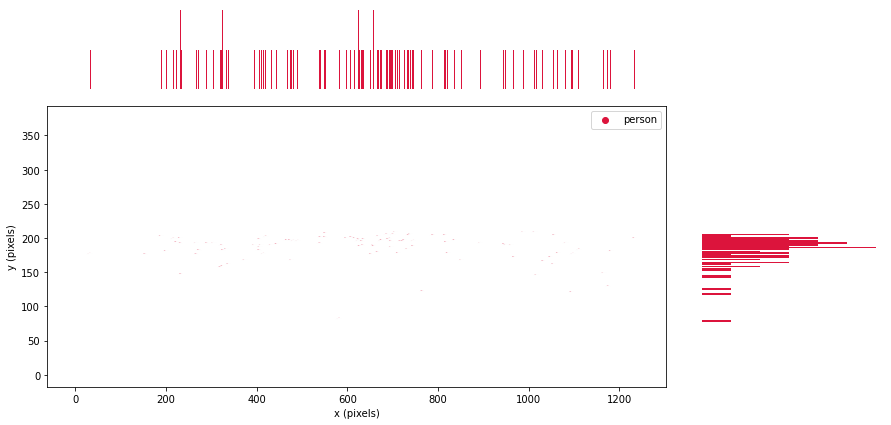

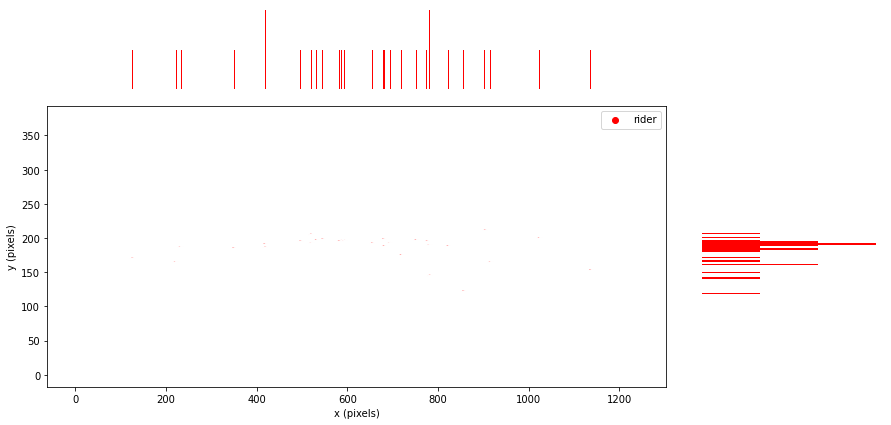

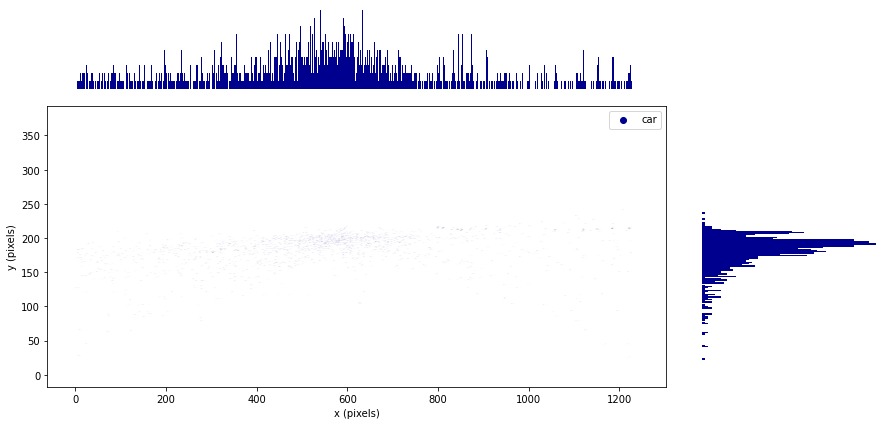

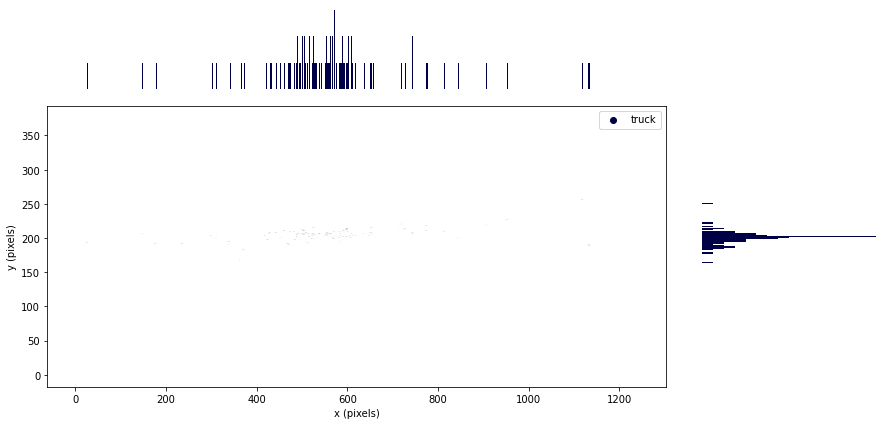

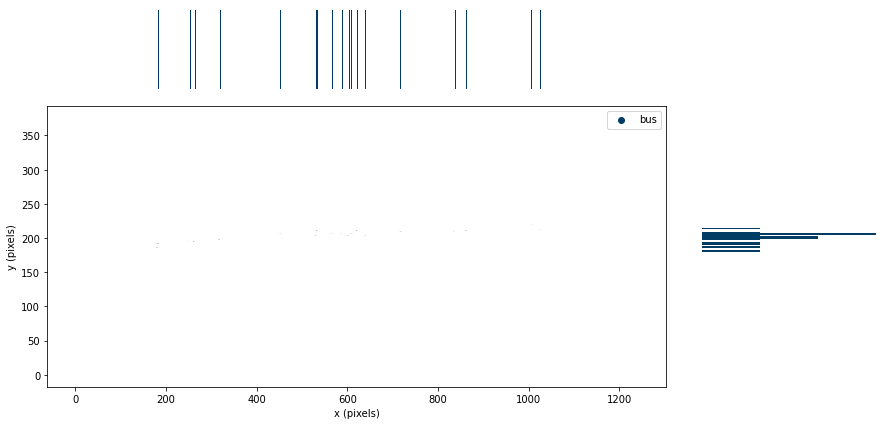

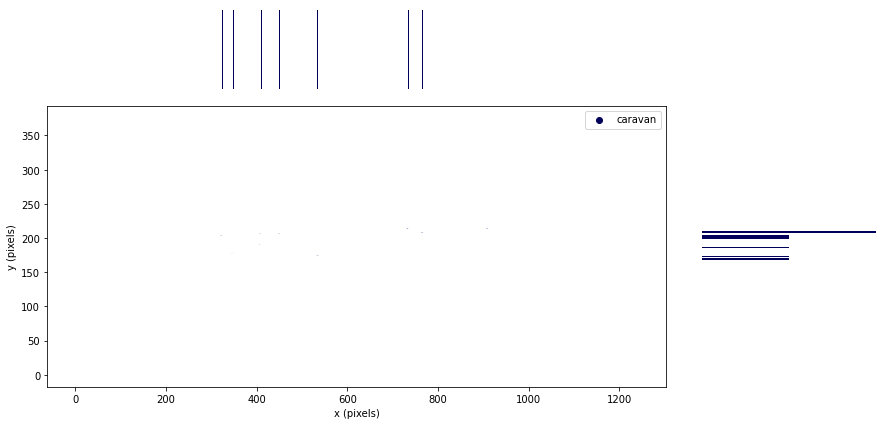

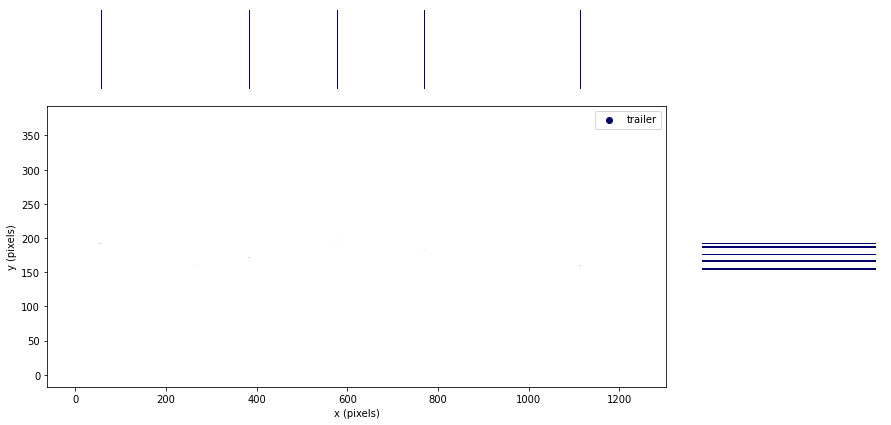

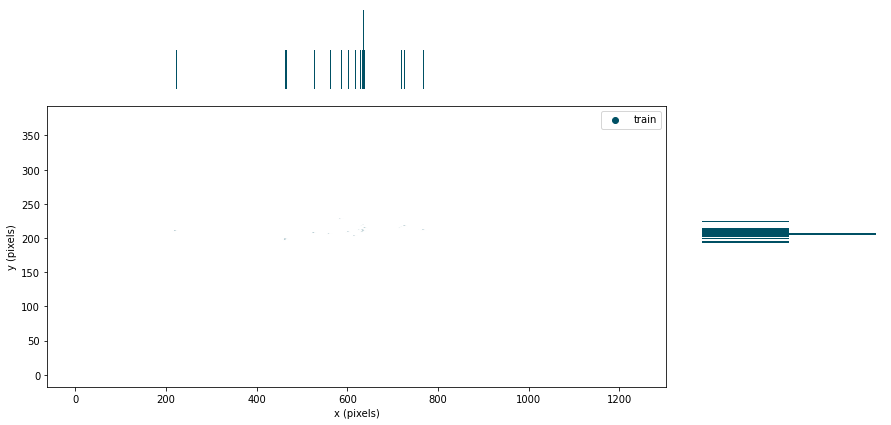

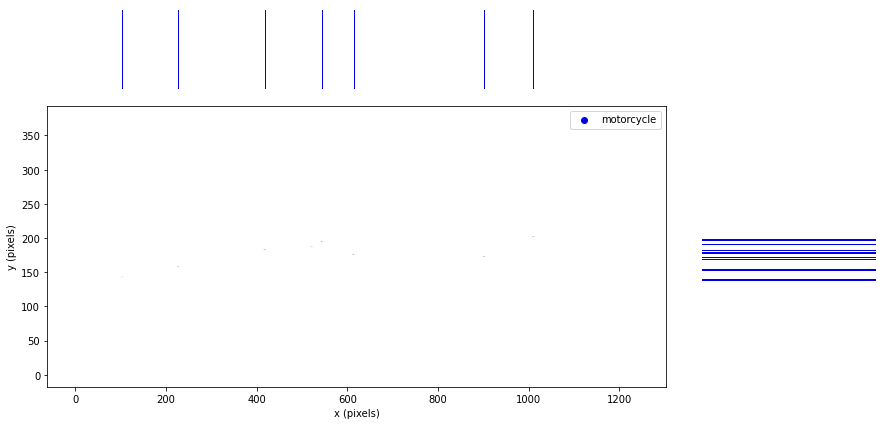

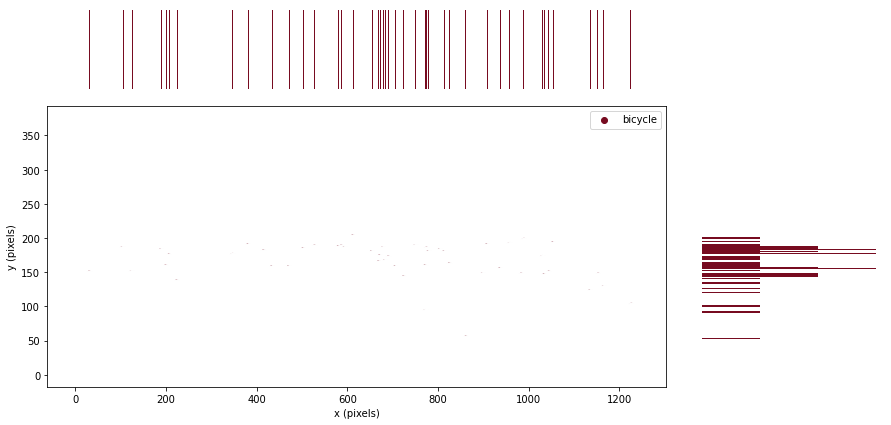

In [21]:
# for each class 
for instance_class in instance_classes:

    # get class name and color
    class_name = instance_class['name']
    class_color = instance_class['color']

    map = class_instance_pixel_occurrences[class_name]
    original_map = map
    original_shape = map.shape
    map = map.flatten()
    
    # map values to interval 0-255
    map = np.interp(map, (map.min(), map.max()), (0, 255))

    # definitions for the axes
    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0, 0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    # get coordinates of pixels
    coordinates = np.indices(original_shape)
    coordinates = coordinates.reshape(coordinates.shape[0], coordinates.shape[1] * coordinates.shape[2])
    cmap = colors.LinearSegmentedColormap.from_list('custom', ['#FFFFFF', '#{:02x}{:02x}{:02x}'.format(class_color[0], class_color[1], class_color[2])], N=256)

    # plot scatter of pixel classes occurrences
    ax_scatter.scatter(coordinates[1], original_shape[0] - coordinates[0], c=map, cmap=cmap, label=class_name)
    ax_scatter.legend(loc='upper right')
    ax_scatter.set_xlabel('x (pixels)')
    ax_scatter.set_ylabel('y (pixels)')
    leg = ax_scatter.get_legend()
    leg.legendHandles[0].set_color('#{:02x}{:02x}{:02x}'.format(class_color[0], class_color[1], class_color[2]))

    # plot distribution of classes over axes
    x_sum = original_map.sum(axis=1)
    y_sum = original_map.sum(axis=0)

    ax_hist_x.bar(list(range(0, original_shape[1])), y_sum, width=2, color=(class_color[0]/255, class_color[1]/255, class_color[2]/255))
    ax_hist_y.barh(list(range(0, original_shape[0])), x_sum, height=2, color=(class_color[0]/255, class_color[1]/255, class_color[2]/255), orientation='horizontal')
    ax_hist_y.invert_yaxis()
    ax_hist_x.axis("off")
    ax_hist_y.axis("off")

    plt.show()